# Disease Prediction Using Machine Learning

This article focuses on implementing a powerful machine learning model capable of predicting human diseases based on the symptoms presented. Let’s dive into how we can effectively approach this problem.

## Approach

### 1. Data Collection
The first and most crucial step in any machine learning project is **data gathering**. For this task, we will utilize a [**dataset**](https://www.kaggle.com/datasets/kaushil268/disease-prediction-using-machine-learning?select=Testing.csv) from Kaggle. The dataset consists of two CSV files: one for training and another for testing. It contains a total of **133 columns**. Out of these, **132 columns** represent various symptoms, while the final column represents the **prognosis** (the disease outcome).

### 2. Data Preprocessing
Data preprocessing is vital for building an effective machine learning model. The quality of the data directly impacts the model’s performance. In this dataset:
- All columns are numeric.
- The **prognosis** column is initially in string format and will be encoded into numeric values using a **label encoder** for machine learning compatibility.

### 3. Model Building
Once the data is gathered and cleaned, we are ready to train our machine learning models. We will explore the following algorithms:
- **Support Vector Classifier (SVC)**
- **Naive Bayes Classifier**
- **Random Forest Classifier**

To evaluate the performance of these models, we will use a **confusion matrix** to assess the accuracy and quality of each model.

### 4. Prediction Approach
After training all three models, we will combine their predictions to form a more robust and reliable disease prediction. This **ensemble method** will ensure that our final output is more accurate and trustworthy by leveraging the strengths of all models.

### 5. Prediction Function Implementation
Finally, we will develop a **prediction function** that:
- Accepts symptom inputs (comma-separated).
- Predicts the disease based on the trained models.
- Outputs the prediction results in a convenient **JSON format** for easy integration.


Ensure that the **Training** and **Testing** datasets are properly downloaded, and place the `train.csv` and `test.csv` files inside the `dataset` folder. 

Launch **Jupyter Notebook** and execute each cell individually to gain a deeper understanding of the code and its workings.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')


# Disease Distribution Analysis

We are analyzing the distribution of diseases in the training dataset to understand the balance of different diseases. By loading and cleaning the data, we ensure it's ready for analysis. We then count the occurrences of each disease to see how frequently they appear in the dataset. After that, we visualize this distribution using a bar plot, which shows the frequency of each disease. This helps us identify if the dataset is balanced or if certain diseases are overrepresented, which is crucial for ensuring the quality and fairness of machine learning models.

# Label Encoding for Target Column

From the above analysis, we can see that the dataset is balanced, meaning that there are exactly 120 samples for each disease, and no further balancing is necessary. It is also important to note that the target column, `prognosis`, is of object datatype, which is not suitable for training machine learning models. Therefore, we will apply a **Label Encoder** to convert the `prognosis` column into numerical format. The Label Encoder works by assigning a unique numerical index to each label. If the total number of unique labels is `n`, the labels will be encoded as integers from 0 to `n-1`.

This conversion is crucial because machine learning models require numerical input for training. By transforming categorical labels into numeric values, we can ensure compatibility with various machine learning algorithms.



In [14]:
def load_and_clean_data(train_path: str, test_path: str) -> tuple:
    """Load and preprocess training and test data"""
    try:
        train = pd.read_csv(train_path).dropna(axis=1)
        test = pd.read_csv(test_path).dropna(axis=1)

        # Validate data shape
        assert train.shape[1] == 133, "Invalid training data columns"
        assert test.shape[1] == 133, "Invalid test data columns"

        # Split features and target
        X = train.iloc[:, :-1]
        y = train.iloc[:, -1]

        X_test = test.iloc[:, :-1]
        y_test = test.iloc[:, -1]

        # Encode labels
        le = LabelEncoder()
        y = le.fit_transform(y)
        y_test = le.transform(y_test)

        return train, X, y, X_test, y_test, le

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

train, X, y, X_test, y_test, label_encoder = load_and_clean_data(
    train_path='dataset/Training.csv',
    test_path='dataset/Testing.csv'
)

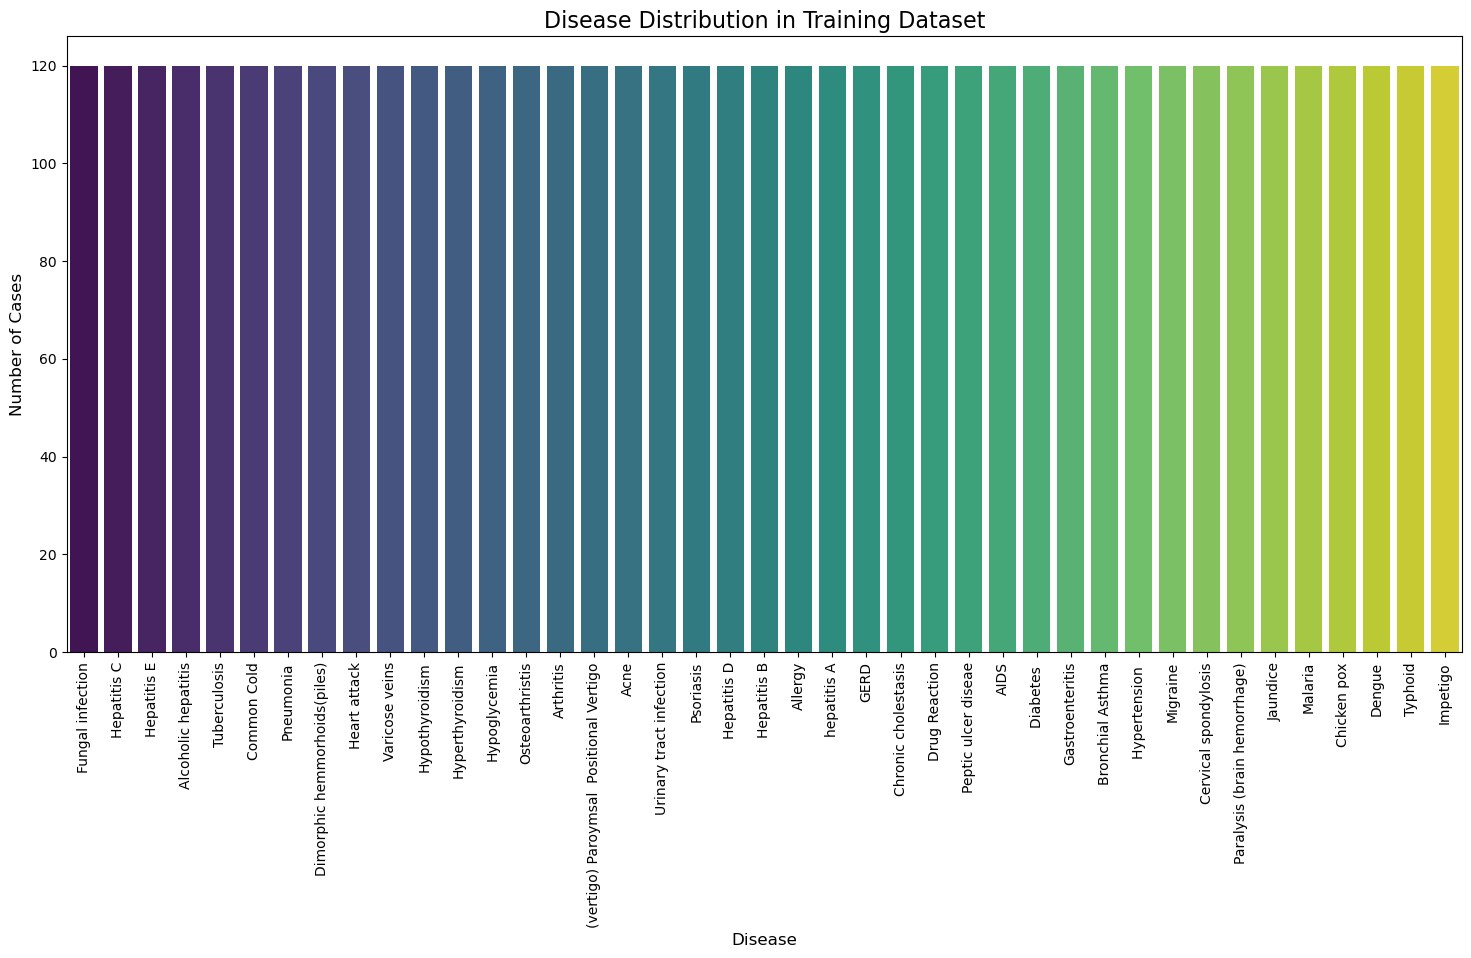

In [15]:
def plot_disease_distribution(data):
    disease_counts = data["prognosis"].value_counts()
    disease_df = pd.DataFrame({"Disease": disease_counts.index, "Count": disease_counts.values})
    
    plt.figure(figsize=(18,8))
    sns.barplot(x="Disease", y="Count", data=disease_df, hue="Disease", palette='viridis', legend=False)
    plt.xticks(rotation=90)
    plt.title("Disease Distribution in Training Dataset", fontsize=16)
    plt.ylabel("Number of Cases", fontsize=12)
    plt.xlabel("Disease", fontsize=12)
    plt.show()

plot_disease_distribution(train)

# Model Building and Evaluation

In this section, we will delve into the process of building and evaluating machine learning models. We will be using **K-Fold Cross-Validation** to assess the performance of three powerful classifiers: **Support Vector Classifier (SVC)**, **Gaussian Naive Bayes**, and **Random Forest Classifier**. Before diving into the implementation, let's first explore what K-Fold Cross-Validation and these machine learning models are all about.

## K-Fold Cross-Validation:
K-Fold Cross-Validation is a robust method for assessing the performance of machine learning models. In this approach, the dataset is divided into **k subsets** or **folds**. The model is trained on **k-1 folds** and tested on the remaining fold. This process is repeated **k times**, each time using a different fold for testing and the remaining for training. The results from all folds are then averaged to produce a more reliable estimate of the model’s performance.

## Support Vector Classifier (SVC):
Support Vector Classifier (SVC) is a **discriminative classifier** that aims to find an **optimal hyperplane** that separates the data into distinct categories. It works by maximizing the margin between data points of different classes in a high-dimensional space, making it effective for both linear and non-linear classification tasks. The SVC algorithm is particularly powerful when dealing with complex and high-dimensional datasets.

## Gaussian Naive Bayes Classifier:
The Gaussian Naive Bayes classifier is a **probabilistic model** that applies **Bayes Theorem** to predict the class of a data point based on its features. It assumes that the features follow a **Gaussian distribution** (normal distribution), which is why it’s particularly effective when dealing with continuous data. The Naive Bayes classifier is fast and works well with high-dimensional data, making it a solid choice for many classification problems.

## Random Forest Classifier:
Random Forest is an **ensemble learning** algorithm that combines multiple decision trees to make predictions. Each individual tree in the forest is trained on a random subset of the data, and its prediction is made based on its own decision boundaries. The final output is determined by the **mode** of all the individual tree predictions. This approach improves model accuracy by reducing overfitting and providing more robust results compared to individual decision trees.

---

Now that we've outlined the models, we are ready to proceed with the **K-Fold Cross-Validation** process to evaluate their performance.


In [16]:
class DiseaseClassifier:
    def __init__(self, model, model_name: str):
        self.model = model
        self.name = model_name
        self.train_accuracy = None
        self.test_accuracy = None
        self.cv_scores = None

    def train_evaluate(self, X, y, X_test, y_test, cv=5):
        """Train model and evaluate performance"""
        # Training
        self.model.fit(X, y)

        # Cross-validation
        self.cv_scores = cross_val_score(self.model, X, y, cv=cv)

        # Predictions
        train_preds = self.model.predict(X)
        test_preds = self.model.predict(X_test)

        # Metrics
        self.train_accuracy = accuracy_score(y, train_preds)
        self.test_accuracy = accuracy_score(y_test, test_preds)

        # Generate reports
        print(f"\n{'=' * 40}")
        print(f"{self.name} Performance")
        print(f"{'=' * 40}")
        print(f"Cross-validation scores (mean ± std): "
              f"{self.cv_scores.mean():.2f} ± {self.cv_scores.std():.2f}")
        print(f"Training Accuracy: {self.train_accuracy:.2%}")
        print(f"Test Accuracy: {self.test_accuracy:.2%}")
        print("\nClassification Report:")
        print(classification_report(y_test, test_preds))

        # Confusion Matrix Visualization
        self.plot_confusion_matrix(y_test, test_preds)

    def plot_confusion_matrix(self, y_true, y_pred):
        """Plot enhanced confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(15, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    cbar=False, annot_kws={'size': 8})
        plt.title(f'{self.name} Confusion Matrix', fontsize=14)
        plt.xlabel('Predicted Labels', fontsize=12)
        plt.ylabel('True Labels', fontsize=12)
        plt.show()

# Defining and Initializing Machine Learning Models

In this step, we define three different machine learning models for classification: Support Vector Machine (SVC), Naive Bayes (GaussianNB), and Random Forest (RandomForestClassifier). The Support Vector Machine is configured with `probability=True` to enable probability estimates, which can be useful for certain types of classification tasks. The Random Forest classifier is initialized with 200 trees, a maximum depth of 10, and balanced class weights to handle class imbalance. Each of these models is encapsulated in the `DiseaseClassifier` class, which will manage training, evaluation, and performance reporting for each model. These models will then be used to compare their performance on the dataset.


In [17]:
models = [
    DiseaseClassifier(SVC(probability=True), "Support Vector Machine"),
    DiseaseClassifier(GaussianNB(), "Naive Bayes"),
    DiseaseClassifier(
        RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42,
            class_weight='balanced'
        ),
        "Random Forest"
    )
]

# Training and Evaluating Models

In this section, we train and evaluate the performance of all the models defined earlier. For each model, the `train_evaluate` method is called, which performs the training on the training data (`X`, `y`) and evaluates its accuracy on both the training data and test data (`X_test`, `y_test`). Additionally, the method calculates cross-validation scores to assess model performance more robustly. The evaluation results, including the training accuracy, test accuracy, cross-validation mean, and standard deviation, are stored in a `performance_data` list. This data is later used for comparison and visualization of the model performances.



Support Vector Machine Performance
Cross-validation scores (mean ± std): 1.00 ± 0.00
Training Accuracy: 100.00%
Test Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      

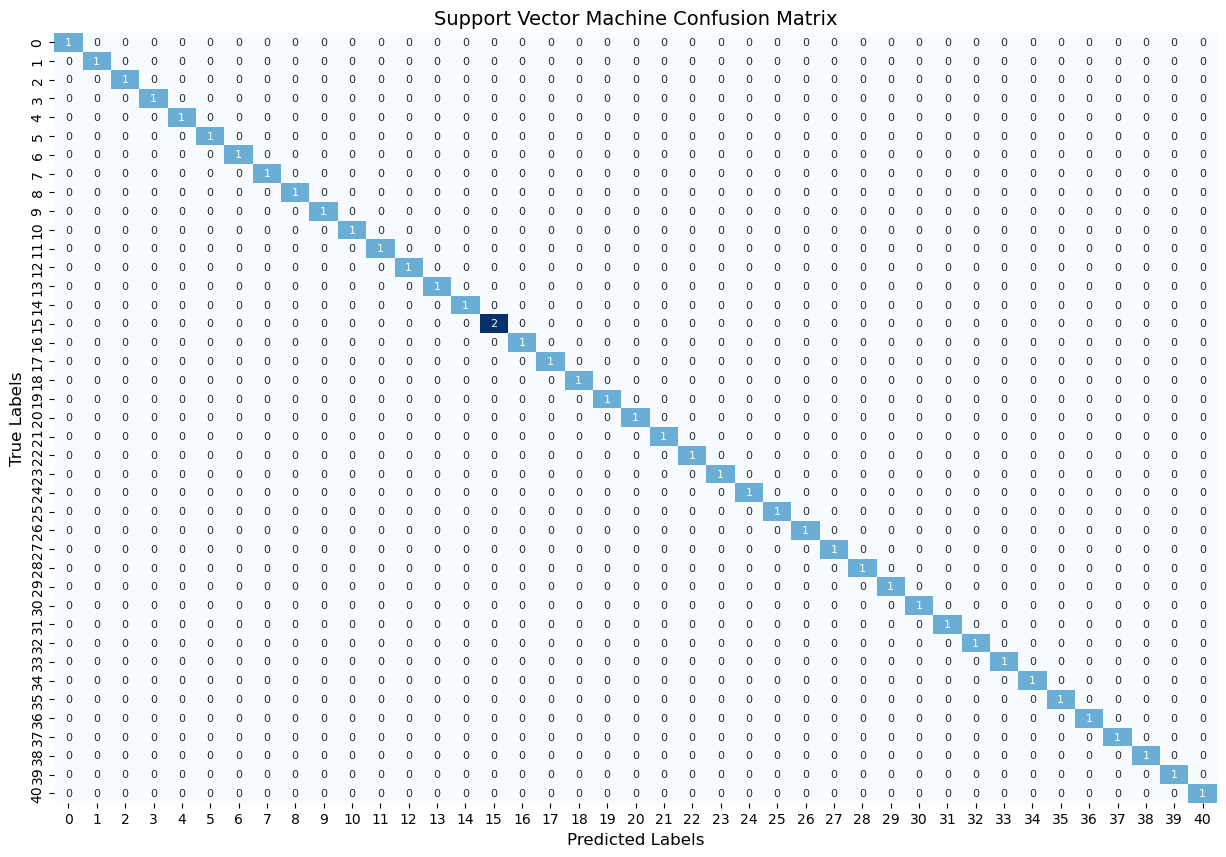


Naive Bayes Performance
Cross-validation scores (mean ± std): 1.00 ± 0.00
Training Accuracy: 100.00%
Test Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1

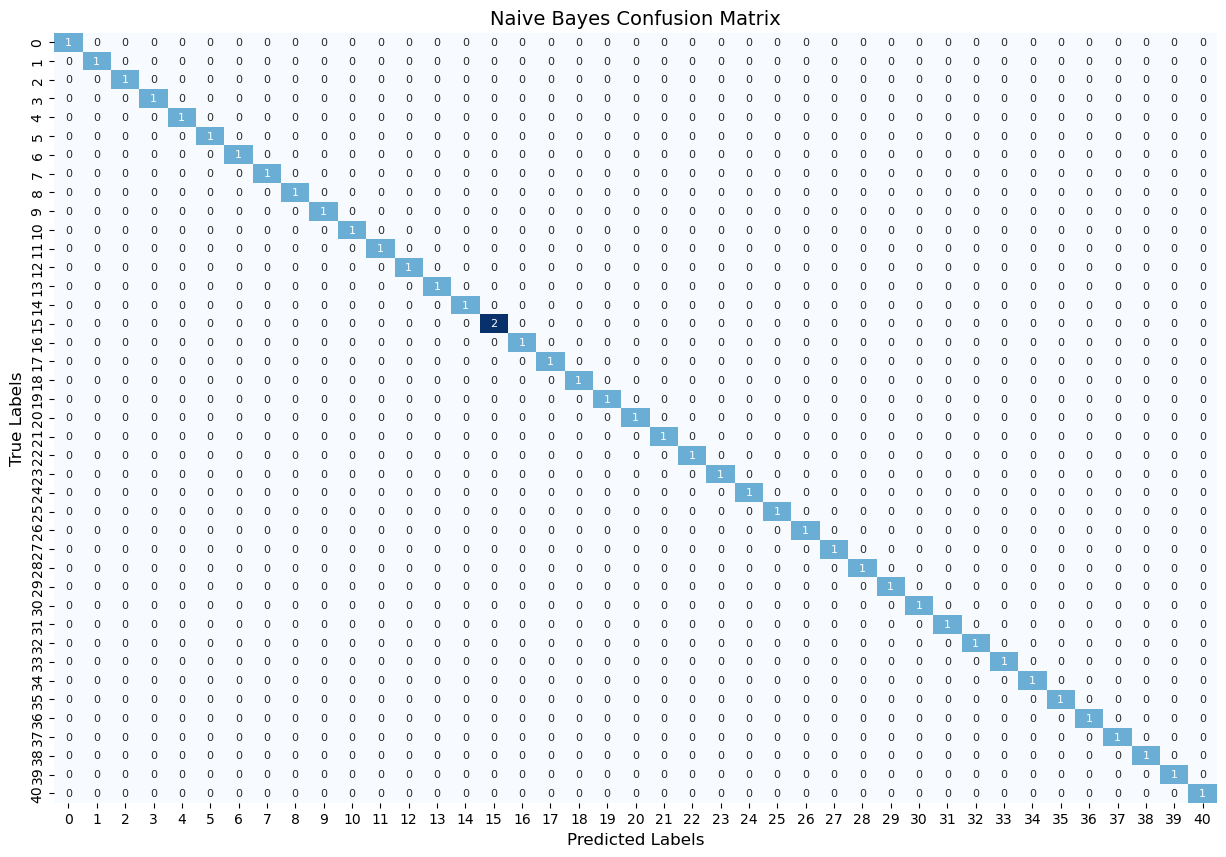


Random Forest Performance
Cross-validation scores (mean ± std): 1.00 ± 0.00
Training Accuracy: 100.00%
Test Accuracy: 97.62%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      

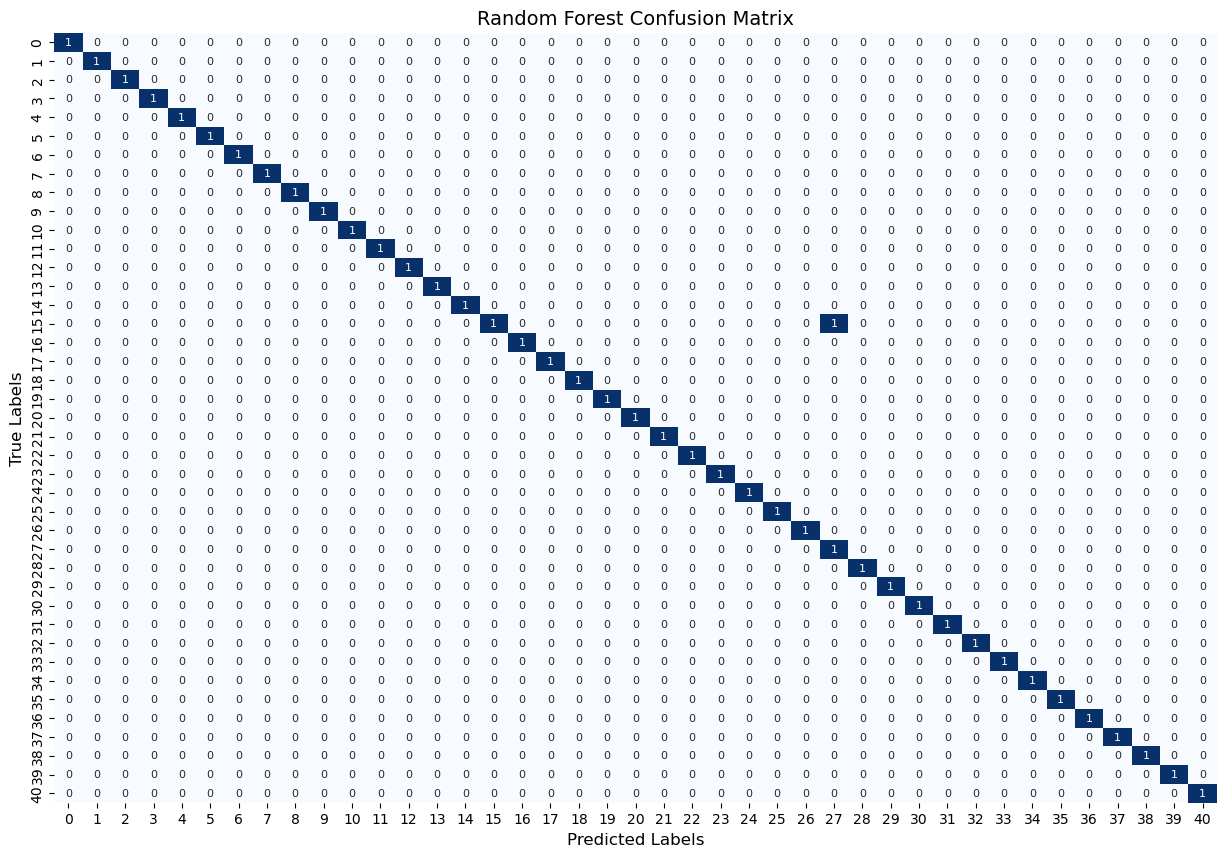

In [18]:
# Train and evaluate models
performance_data = []
for model in models:
    model.train_evaluate(X, y, X_test, y_test)
    performance_data.append({
        'Model': model.name,
        'Train Accuracy': model.train_accuracy,
        'Test Accuracy': model.test_accuracy,
        'CV Mean': model.cv_scores.mean(),
        'CV Std': model.cv_scores.std()
    })

# Performance Comparison Visualization

In this step, we visualize the performance of the models by plotting a bar graph that shows the test accuracy for each model. The plot is enhanced by including the accuracy values above each bar for better clarity. The title of the plot is placed higher to avoid any overlap with the bars, and the y-axis is limited to a range from 0.8 to 1.0 to highlight the accuracy differences. The x-axis labels are rotated for better readability, and the accuracy values are displayed as percentages, giving us a clear and concise view of how each model performs on the test set. This visualization helps in identifying the model with the best performance based on the test accuracy.


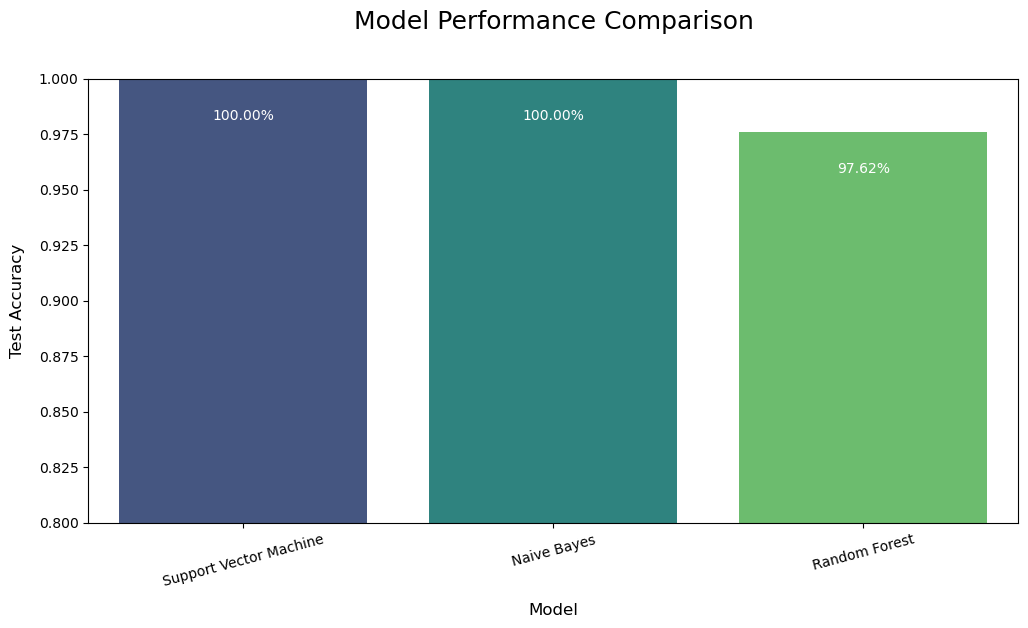

In [25]:
    # Performance comparison visualization
    performance_df = pd.DataFrame(performance_data)
    plt.figure(figsize=(12, 6))
    
    # Create more space for the title
    plt.subplots_adjust(top=0.85)
    
    # Create a bar plot for model performance comparison
    sns.barplot(x='Model', y='Test Accuracy', data=performance_df, palette='viridis')
    
    # Set the title with a higher position
    plt.title('Model Performance Comparison', 
             fontsize=18, 
             pad=20,  # Increase padding from the top of the plot
             y=1.05)  # Move the title upwards
    
    # Set y-axis limits and labels
    plt.ylim(0.8, 1.0)
    plt.ylabel('Test Accuracy', fontsize=12, labelpad=10)
    plt.xlabel('Model', fontsize=12, labelpad=10)
    plt.xticks(rotation=15)  # Rotate x-axis labels for better readability
    
    # Add accuracy text on top of each bar
    for index, row in performance_df.iterrows():
        plt.text(index, 
                 row['Test Accuracy'] - 0.02,  # Adjust text position
                 f"{row['Test Accuracy']:.2%}",  # Format accuracy as percentage
                 ha='center',  # Horizontal alignment
                 va='bottom',  # Vertical alignment
                 fontsize=10,  # Text size
                 color='white')  # Text color
    
    # Display the plot
    plt.show()

# Feature Importance for Random Forest

In this section, we assess the feature importance of the Random Forest model. The code first checks if the model is part of a pipeline and extracts the `RandomForestClassifier` from it. Then, it checks if the model has the `feature_importances_` attribute, which is available in Random Forest models. If the attribute is present, the importance scores of each feature are extracted and visualized in a bar plot. The top 15 features are displayed based on their importance score, allowing us to understand which features contribute the most to the model's decision-making process. This step provides insights into the relevance of different features, which can be valuable for model interpretation and feature selection.


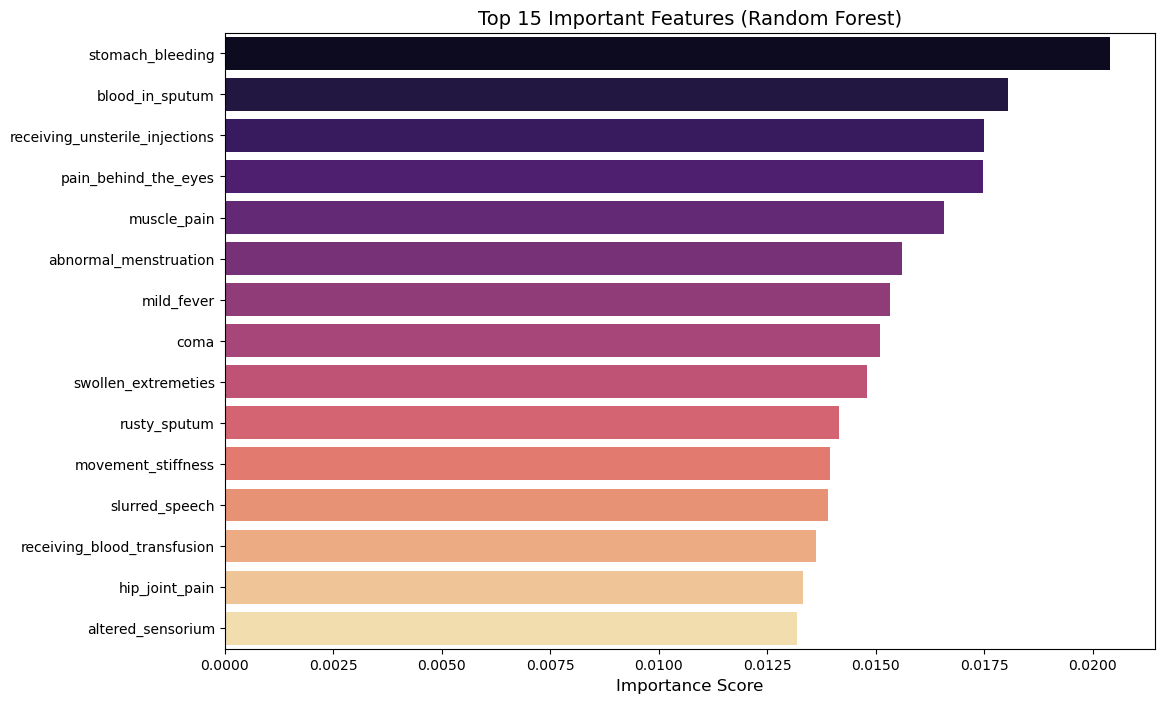

In [30]:
# Feature Importance for Random Forest
# Check if the model is a pipeline. If so, extract the RandomForestClassifier from its named_steps.
if isinstance(models[2].model, Pipeline):
    rf_model = models[2].model.named_steps.get('randomforestclassifier')
else:
    rf_model = models[2].model

if rf_model is None:
    print("Random Forest model not found in the pipeline!")
elif hasattr(rf_model, 'feature_importances_'):
    importances = rf_model.feature_importances_
    features = X.columns  # Assuming X is your DataFrame of features
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
    top_features = feature_importance.sort_values('Importance', ascending=False).head(15)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='magma')
    plt.title('Top 15 Important Features (Random Forest)', fontsize=14)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('')
    plt.show()
else:
    print("The model does not support feature importances.")


# Save Best Model

In this step, we identify and save the best-performing model based on its test accuracy. We use the `max()` function to find the model with the highest test accuracy from the list of trained models. Once identified, we save the model using `joblib.dump()` into a `.pkl` file, where the model's name is used as part of the file name for easy identification. This allows us to later reload and use the best model for future predictions without retraining it. The name of the saved model is printed to confirm the process.


In [31]:
# Save best model
best_model = max(models, key=lambda x: x.test_accuracy)
joblib.dump(best_model.model, f'best_{best_model.name.replace(" ", "_")}.pkl')
print(f"\nSaved best model: {best_model.name}")


Saved best model: Support Vector Machine
